# Random Forest

### Imports

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from joblib import dump, load

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn import tree

In [3]:
from preprocessing import reemplazarNulls,reemplazarCategoricas,reemplazarFechas,regularizar,targetBooleano

[###] All Done                                              


In [4]:
from utilities import score, df_feat, df_targ, train_val

### Codigo a correr

In [5]:
MAX_JOBS = 5

**Run :** Entrenar Nuevamente o Cargar Entrenado

In [6]:
runSimple = False
runValidated = False
runReg = False

**Save :** Guardar Modelo (pisa anterior)

In [7]:
saveSimple = True
saveValidated = True
saveReg = True

### Preprocesamiento

In [8]:
targetBooleano(df_targ, inplace=True)
reemplazarNulls(df_feat , inplace=True)
reemplazarCategoricas(df_feat , inplace=True)
reemplazarFechas(df_feat , inplace=True)
df_feat_r = regularizar(df_feat)

In [9]:
df_feat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102356 entries, 0 to 102355
Data columns (total 24 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   id                            102356 non-null  int64  
 1   direccion_viento_tarde        102356 non-null  float64
 2   direccion_viento_temprano     102356 non-null  float64
 3   horas_de_sol                  102356 non-null  float64
 4   humedad_tarde                 102356 non-null  float64
 5   humedad_temprano              102356 non-null  float64
 6   llovieron_hamburguesas_hoy    102356 non-null  bool   
 7   mm_evaporados_agua            102356 non-null  float64
 8   mm_lluvia_dia                 102356 non-null  float64
 9   nubosidad_tarde               102356 non-null  float64
 10  nubosidad_temprano            102356 non-null  float64
 11  presion_atmosferica_tarde     102356 non-null  float64
 12  presion_atmosferica_temprano  102356 non-nul

In [10]:
train_feat, val_feat, train_targ, val_targ = train_val( df_feat, df_targ )

In [11]:
train_targ = train_targ.llovieron_hamburguesas_al_dia_siguiente
val_targ = val_targ.llovieron_hamburguesas_al_dia_siguiente

In [12]:
train_feat_r, val_feat_r, train_targ_r, val_targ_r = train_val( df_feat_r, df_targ )
train_targ_r = train_targ_r.llovieron_hamburguesas_al_dia_siguiente
val_targ_r = val_targ_r.llovieron_hamburguesas_al_dia_siguiente

## Entrenamiento

### Simple

In [13]:
if (runSimple):
    forest_simple = RandomForestClassifier(
        random_state=1,
        max_depth=3,
        min_samples_split=200,
    )
    forest_simple.fit( train_feat, train_targ )
    
    # Guardar
    if(saveSimple):
        dump(forest_simple, 'models/Ensambles/forest_simple.sk') 
else:
    # Cargar
    forest_simple = load('models/Ensambles/forest_simple.sk')

AUC-ROC: 0.825984730995354
ACCURACY: 0.8159437280187574
PRESICION: 0.8152173913043478
RECALL: 0.2292576419213974
CONFUSION MATRIX
CPU times: user 288 ms, sys: 16.5 ms, total: 305 ms
Wall time: 272 ms


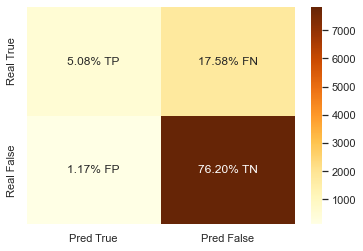

In [14]:
%%time
pred_s = forest_simple.predict(val_feat)
prob_s = forest_simple.predict_proba(val_feat)
score(val_targ, pred_s, prob_s[:,1])

### Validado

In [15]:
if( runValidated ):
    forest = RandomForestClassifier(
        random_state=1,
    )
    
    params = {
        'max_depth': np.arange(3, 20, 1),
        'min_samples_leaf': np.arange(100, 1000, 100),
        'criterion': ['gini', 'entropy'],
        'n_estimators': np.arange(100,500,100),
    }
    
    forest_grid = HalvingGridSearchCV(
        forest,
        params,
        scoring='roc_auc',
        n_jobs=MAX_JOBS,
        return_train_score=True,
        verbose=1
    ).fit(train_feat, train_targ)
    
    # Guardar
    if(saveValidated):
        dump(forest_grid, 'models/Ensambles/forest_grid.sk')
        dump(forest_grid.best_estimator_, 'models/Ensambles/forest.sk')
else:
    # Cargar
    forest_grid = load('models/Ensambles/forest_grid.sk')

In [16]:
print(f"Best score: {forest_grid.best_score_}")
print(f"Best params {forest_grid.best_params_}")

Best score: 0.8690311842379943
Best params {'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 100, 'n_estimators': 300}


In [17]:
forest = forest_grid.best_estimator_

AUC-ROC: 0.8663429568803397
ACCURACY: 0.8390973036342321
PRESICION: 0.7517619420516837
RECALL: 0.4192139737991266
CONFUSION MATRIX
CPU times: user 841 ms, sys: 16.4 ms, total: 858 ms
Wall time: 828 ms


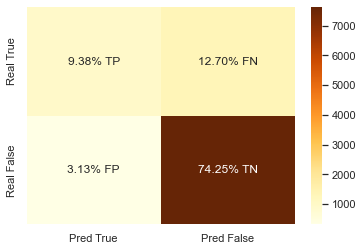

In [18]:
%%time
pred = forest.predict(val_feat)
prob = forest.predict_proba(val_feat)
score(val_targ, pred, prob[:,1])

### Reg

In [19]:
if( runReg ):
    forest2 = RandomForestClassifier(
        random_state=1,
    )
    
    params = {
        'max_depth': np.arange(3, 20, 1),
        'min_samples_leaf': np.arange(100, 1000, 100),
        'criterion': ['gini', 'entropy'],
        'n_estimators': np.arange(100,500,100),
    }
    
    forest_grid2 = HalvingGridSearchCV(
        forest2,
        params,
        scoring='roc_auc',
        n_jobs=MAX_JOBS,
        return_train_score=True,
        verbose=1
    ).fit(train_feat_r, train_targ_r)
    
    # Guardar
    if(saveReg):
        dump(forest_grid2, 'models/Ensambles/forest_r_grid.sk')
        dump(forest_grid2.best_estimator_, 'models/Ensambles/forest_r.sk')
else:
    # Cargar
    forest_grid2 = load('models/Ensambles/forest_r_grid.sk')

In [20]:
print(f"Best score: {forest_grid2.best_score_}")
print(f"Best params {forest_grid2.best_params_}")

Best score: 0.8686629309895244
Best params {'criterion': 'gini', 'max_depth': 18, 'min_samples_leaf': 100, 'n_estimators': 100}


In [21]:
forest2 = forest_grid2.best_estimator_

AUC-ROC: 0.8660710890211988
ACCURACY: 0.838022665103556
PRESICION: 0.7383107088989442
RECALL: 0.4275109170305677
CONFUSION MATRIX
CPU times: user 354 ms, sys: 8.63 ms, total: 362 ms
Wall time: 329 ms


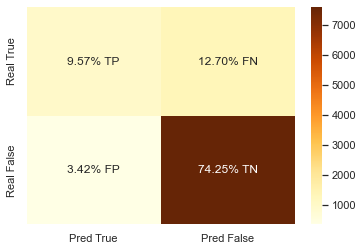

In [22]:
%%time
pred = forest2.predict(val_feat_r)
prob = forest2.predict_proba(val_feat_r)
score(val_targ_r, pred, prob[:,1])